# Predicción de anomalías, en el sector industrial

 __Nombre:__ Adonis González

## 1. Inicialización y carga de utilidades

El código siguiente carga algunos paquetes necesarios para la práctica y lee los datos que utilizaremos para entrenar los modelos. Definimos también algunas utilidades para preprocesar los datos y generar los datasets.

In [1]:
import sys  
sys.path.insert(0, '../src/')

from imports import *
from plot_functions import * 
from model_functions import *
from data_functions import *
from metric_fuctions import *

A continuación se muestra las versión de tensorflow y keras y el dispositivo GPU utilizado para enfrentar el problema de la de detección de anomalías. 

In [2]:
print("TF version   : ", tf.__version__)
print("Keras version   : ", keras.__version__)

print("GPU available: ", tf.config.list_physical_devices('GPU'))
local_prot = device_lib.list_local_devices()
print([x.physical_device_desc for x in local_prot if x.device_type == 'GPU'])

TF version   :  2.4.1
Keras version   :  2.4.3
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['device: 0, name: GeForce RTX 2080 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5']


Paths sources:

In [3]:
# paths 
ROOT_DIR = os.path.abspath("../")
data_dir = os.path.join(ROOT_DIR, "data")
data_1 = os.path.join(data_dir, "1")
train = os.path.join(data_1, "PM_train.csv")
test = os.path.join(data_1, "PM_test.csv")
gtruth = os.path.join(data_1, "PM_truth.csv")

Creamos los headers names de las columnas del conjunto de datos.

In [4]:
sensores = ["measure_" + str(i) for i in range(1, 22)]
col_names=["id", "cycle_time", "op_sett_1", "op_sett_2", "op_sett_3"] + sensores
print(col_names)

['id', 'cycle_time', 'op_sett_1', 'op_sett_2', 'op_sett_3', 'measure_1', 'measure_2', 'measure_3', 'measure_4', 'measure_5', 'measure_6', 'measure_7', 'measure_8', 'measure_9', 'measure_10', 'measure_11', 'measure_12', 'measure_13', 'measure_14', 'measure_15', 'measure_16', 'measure_17', 'measure_18', 'measure_19', 'measure_20', 'measure_21']


## 2. Exploración y preprocesado de los datos

En este apartado exploraremos la base de datos y prepararemos la carga de estos.

Las redes neuronales artificiales, como el resto de modelos de aprendizaje automático, requieren que los datos de entrada estén en un formato específico para poder trabajar de forma correcta. Concretamente estos deben estar en formato numérico y se recomienda que estén estandarizados. Además, en caso de haber más de dos clases será recomendable también binarizarlas.

Leemos los dataset de training, test y groundtruth como pandas Dataframe.

In [5]:
# cargamos datos como dataframes
df_train = pd.read_csv(train, sep=";", header=None)
df_test = pd.read_csv(test, sep=";", header=None)
df_truth = pd.read_csv(gtruth, sep=";", header=None)

Cargamos los headers previamente creados a las columnas del los dos dataframes, train y test.

In [6]:
df_train.columns = col_names
df_test.columns = col_names

Miramos dimensiones del conjunto de train, test y truth.

In [7]:
print(f' La dimensión del conjunto de entranmiento es {df_train.shape}')
print(f' La dimensión del conjunto de test es {df_test.shape}')
print(f' La dimensión del conjunto de truth es {df_truth.shape}')

 La dimensión del conjunto de entranmiento es (20631, 26)
 La dimensión del conjunto de test es (13096, 26)
 La dimensión del conjunto de truth es (100, 1)


Tenemos el primer contacto con el dataset, observamos algunos valores. Se muestran algunas columnas, filas de los 3 sets.

__Train__

In [8]:
df_train.iloc[0:195, 0:8]

,id,cycle_time,op_sett_1,op_sett_2,op_sett_3,measure_1,measure_2,measure_3
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85
...,...,...,...,...,...,...,...,...
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41
192,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84
193,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05


__Test__

In [9]:
df_test.iloc[25:40, 0:8]

,id,cycle_time,op_sett_1,op_sett_2,op_sett_3,measure_1,measure_2,measure_3
25,1,26,0.0047,-0.0005,100.0,518.67,642.48,1583.28
26,1,27,-0.0007,0.0001,100.0,518.67,642.08,1586.65
27,1,28,0.0022,0.0005,100.0,518.67,641.93,1594.25
28,1,29,0.0014,0.0001,100.0,518.67,641.95,1587.15
29,1,30,-0.0025,0.0004,100.0,518.67,642.79,1585.72
30,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22
31,2,1,-0.0009,0.0004,100.0,518.67,642.66,1589.30
32,2,2,-0.0011,0.0002,100.0,518.67,642.51,1588.43
33,2,3,0.0002,0.0003,100.0,518.67,642.58,1595.60
34,2,4,0.0025,0.0001,100.0,518.67,642.31,1583.43


__Truth__

In [10]:
df_truth.head(10)

,0
0,112
1,98
2,69
3,82
4,91
5,93
6,91
7,95
8,111
9,96


In [11]:
df_train.dtypes

id              int64
cycle_time      int64
op_sett_1     float64
op_sett_2     float64
op_sett_3     float64
measure_1     float64
measure_2     float64
measure_3     float64
measure_4     float64
measure_5     float64
measure_6     float64
measure_7     float64
measure_8     float64
measure_9     float64
measure_10    float64
measure_11    float64
measure_12    float64
measure_13    float64
measure_14    float64
measure_15    float64
measure_16    float64
measure_17      int64
measure_18      int64
measure_19    float64
measure_20    float64
measure_21    float64
dtype: object

Miramos si tenemos datos nulos.

In [12]:
check_df_null(df_train)
check_df_null(df_test)

No tenemos datos nulos en los conjuntos de datos.

Mostramos los primeros estadísticos de las variables numéricas:

In [13]:
df_train.describe()

,id,cycle_time,op_sett_1,op_sett_2,op_sett_3,measure_1,measure_2,measure_3,measure_4,measure_5,...,measure_12,measure_13,measure_14,measure_15,measure_16,measure_17,measure_18,measure_19,measure_20,measure_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,84.421456,3.000000e-02,393.210654,2388.0,100.0,38.816271,232.897054
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.375050,1.387812e-17,1.548763,0.0,0.0,0.180746,1.082509
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,83.249000,3.000000e-02,388.000000,2388.0,100.0,38.140000,228.942000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,84.149000,3.000000e-02,392.000000,2388.0,100.0,38.700000,232.218000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,84.389000,3.000000e-02,393.000000,2388.0,100.0,38.830000,232.979000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,84.656000,3.000000e-02,394.000000,2388.0,100.0,38.950000,233.668000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,85.848000,3.000000e-02,400.000000,2388.0,100.0,39.430000,236.184000


Visualizamos mediante histogramas las variables numéricas:

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'cycle_time'}>,
        <AxesSubplot:title={'center':'op_sett_1'}>,
        <AxesSubplot:title={'center':'op_sett_2'}>,
        <AxesSubplot:title={'center':'op_sett_3'}>],
       [<AxesSubplot:title={'center':'measure_1'}>,
        <AxesSubplot:title={'center':'measure_2'}>,
        <AxesSubplot:title={'center':'measure_3'}>,
        <AxesSubplot:title={'center':'measure_4'}>,
        <AxesSubplot:title={'center':'measure_5'}>],
       [<AxesSubplot:title={'center':'measure_6'}>,
        <AxesSubplot:title={'center':'measure_7'}>,
        <AxesSubplot:title={'center':'measure_8'}>,
        <AxesSubplot:title={'center':'measure_9'}>,
        <AxesSubplot:title={'center':'measure_10'}>],
       [<AxesSubplot:title={'center':'measure_11'}>,
        <AxesSubplot:title={'center':'measure_12'}>,
        <AxesSubplot:title={'center':'measure_13'}>,
        <AxesSubplot:title={'center':'measure_14'}>,
        <A

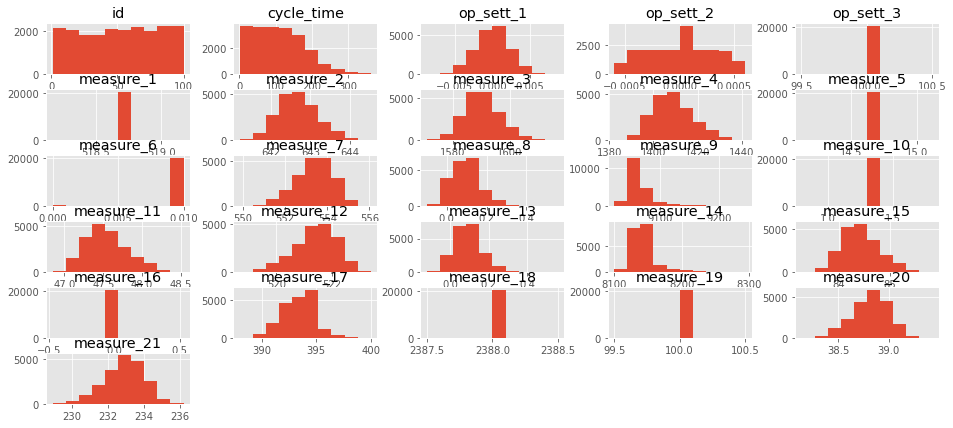

In [14]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 7]

df_train.hist()

<AxesSubplot:>

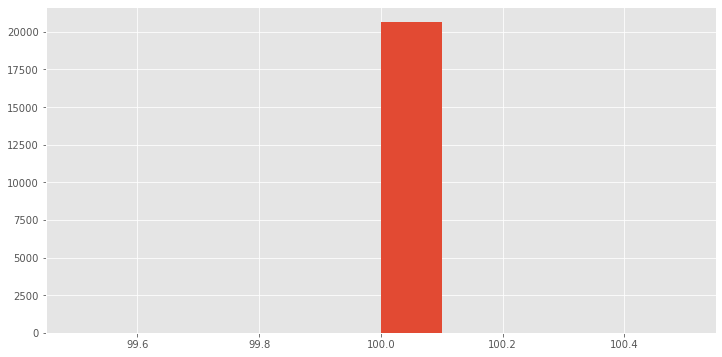

In [15]:
plt.rcParams['figure.figsize'] = [12, 6]
df_train.op_sett_3.hist()

Eliminamos las columnas con valores constantes.

In [16]:
df_train.drop(columns=['op_sett_3',
                       'measure_1',
                       'measure_5',
                       'measure_10',
                       'measure_16',
                       'measure_18',
                       'measure_19'],inplace=True)

Añadimos la columna RUL al conjunto de entrenamiento. Esta agregación de característica se realiza porque los datos de esta columna los conocemos del ciclo máximo de cada id, pues, el ciclo maximo de cada id, se resta entre el ciclo actual. Es decir, el número de ciclos operativos después del último ciclo que el motor seguirá funcionando. 

In [17]:
# solo mostramos la columna nueva, y las que intervienenn en la agregación de caracteristicas
df = prepare_train_data(df_train)
df.iloc[0:193, [0, 1, -1]]

,id,cycle_time,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187
...,...,...,...
188,1,189,3
189,1,190,2
190,1,191,1
191,1,192,0


Printamos la matrix de correlaciones de todas las variables.

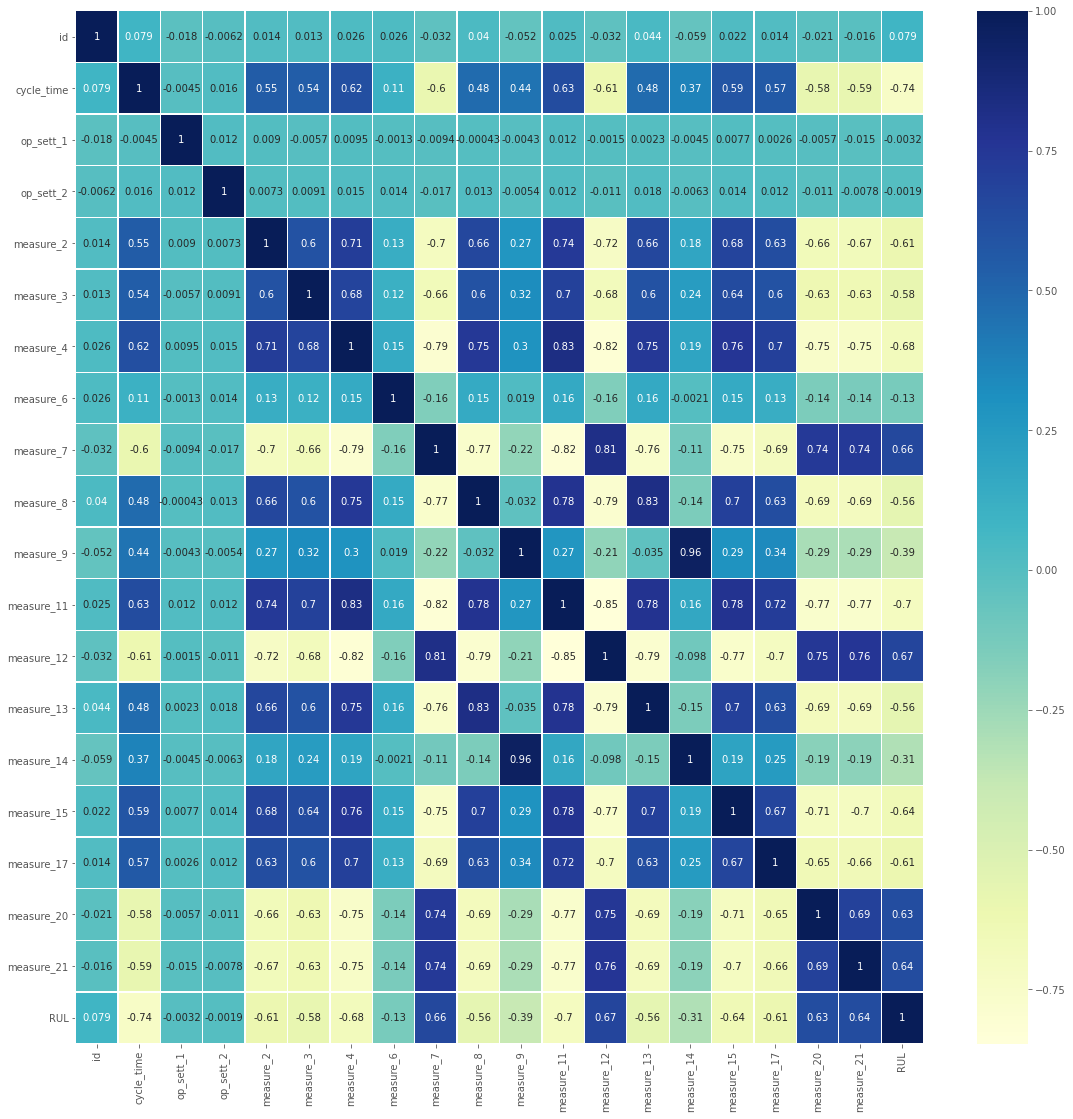

In [18]:
plot_matrix_correlations(df.corr())

In [19]:
id_col = pd.DataFrame(df["id"])
train_df = df.drop(columns = ['id',
                              'op_sett_1',
                              'op_sett_2',
                              'measure_6', 
                              'measure_14'])

print(f'Dimesion del set de train {train_df.shape}')

Dimesion del set de train (20631, 15)


In [20]:
df.columns

Index(['id', 'cycle_time', 'op_sett_1', 'op_sett_2', 'measure_2', 'measure_3',
       'measure_4', 'measure_6', 'measure_7', 'measure_8', 'measure_9',
       'measure_11', 'measure_12', 'measure_13', 'measure_14', 'measure_15',
       'measure_17', 'measure_20', 'measure_21', 'RUL'],
      dtype='object')

Como se ha eliminado columnas del set de entrenamiento, también eliminaremos las mismas en el set de pruebas.

In [22]:
df_test.drop(columns=['measure_18',
                      'measure_19',
                      'measure_5',
                      'measure_1',
                      'op_sett_3',
                      'measure_16',
                      'measure_10',
                      'op_sett_1',
                      'op_sett_2',
                      'measure_6',
                      'measure_14'
                     ],inplace=True)

En el conjunto de test, agrupamos el id de motor y el máximo tiempo de ciclo (último valor del ciclo de cada id). De esta manera solo dejaremos los id (identificadores únicos) con su ciclo máximo.

In [23]:
test_max = df_test.groupby('id')['cycle_time'].max().reset_index()
test_max.columns = ['id','max']
df_test = df_test.merge(test_max, on=['id'], how='left')
test = df_test[df_test['cycle_time'] == df_test['max']].reset_index()


Eliminamos columnas.

In [24]:
test.drop(columns=['index',
                   'max',
                   'id'
                   ], inplace=True)

In [25]:
print(f'Dimesion del set de test {test.shape}')
test.iloc[0:10, [0, 1, 2, -1]]

Dimesion del set de test (100, 14)


,cycle_time,measure_2,measure_3,measure_21
0,31,642.58,1581.22,233.552
1,49,642.55,1586.59,232.618
2,126,642.88,1589.75,232.740
3,106,642.78,1594.53,232.581
4,98,642.27,1589.94,234.117
5,105,643.05,1586.94,233.269
6,160,642.10,1589.59,232.763
7,166,642.59,1591.91,232.465
8,55,642.27,1593.61,233.515
9,192,643.00,1589.50,232.956


Preparamos los conjuntos de test en su forma correcta.

In [26]:
# y_true, variable con los ground truth en forma numpy
y_true = df_truth[0].to_numpy()

# test en forma numpy
X_001_test = test.to_numpy()

In [27]:
X_001_test

array([[  31.   ,  642.58 , 1581.22 , ...,  393.   ,   38.81 ,  233.552],
       [  49.   ,  642.55 , 1586.59 , ...,  391.   ,   38.81 ,  232.618],
       [ 126.   ,  642.88 , 1589.75 , ...,  395.   ,   38.93 ,  232.74 ],
       ...,
       [ 121.   ,  642.68 , 1599.51 , ...,  394.   ,   38.76 ,  233.608],
       [  97.   ,  642.   , 1585.03 , ...,  391.   ,   38.95 ,  233.595],
       [ 198.   ,  642.95 , 1601.62 , ...,  396.   ,   38.7  ,  231.855]])

In [29]:
print(f' La dimensión de la numpy array de entrada es: {len(X_001_test)}')

 La dimensión de la numpy array de entrada es: 100
